## Importando os dados do dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
df = pd.read_csv('../dataset/TelecomX_Data_Normalized.csv')
df.head(1)

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,internet.InternetService,account.Contract,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,account.Charges.Daily
0,No,Female,No,Yes,Yes,9,Yes,DSL,One year,Mailed check,65.6,593.3,2.19


## Normalização, padronização e Encoding

In [3]:
## mudando colunas com apenas dois valores para binário = Churn customer.gender 
# customer.SeniorCitizen customer.Partner customer.Dependents customer.PhoneService
col_bin = ['Churn', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'phone.PhoneService']
df[col_bin] = df[col_bin].apply(lambda x: x.map({'Yes': 1, 'No': 0}))

# customer.gender tratativa sozinho pois os valores são diferentes de sim e não
df['customer.gender'] = df['customer.gender'].map({'Female': 0, 'Male': 1})

df.head(1)

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,internet.InternetService,account.Contract,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,account.Charges.Daily
0,0,0,0,1,1,9,1,DSL,One year,Mailed check,65.6,593.3,2.19


In [4]:
# Verificando os valores únicos das colunas binárias
for col in col_bin:
    print(f"{col}: {df[col].unique()}")

Churn: [0 1]
customer.SeniorCitizen: [0 1]
customer.Partner: [1 0]
customer.Dependents: [1 0]
phone.PhoneService: [1 0]


In [5]:
## utilizando oneHontEncoder para categorias com mais de duas categorias = internet.InternetService account.Contract 
# account.PaymentMethod 

col_cat = ['internet.InternetService', 'account.Contract', 'account.PaymentMethod']
one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),
     col_cat),
     remainder='passthrough'
)

df = one_hot_enc.fit_transform(df)
df = pd.DataFrame(df, columns=one_hot_enc.get_feature_names_out())
df.head()


,onehotencoder__internet.InternetService_DSL,onehotencoder__internet.InternetService_Fiber optic,onehotencoder__internet.InternetService_No,onehotencoder__account.Contract_Month-to-month,onehotencoder__account.Contract_One year,onehotencoder__account.Contract_Two year,onehotencoder__account.PaymentMethod_Bank transfer (automatic),onehotencoder__account.PaymentMethod_Credit card (automatic),onehotencoder__account.PaymentMethod_Electronic check,onehotencoder__account.PaymentMethod_Mailed check,remainder__Churn,remainder__customer.gender,remainder__customer.SeniorCitizen,remainder__customer.Partner,remainder__customer.Dependents,remainder__customer.tenure,remainder__phone.PhoneService,remainder__account.Charges.Monthly,remainder__account.Charges.Total,remainder__account.Charges.Daily
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,9.0,1.0,65.6,593.30,2.19
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,9.0,1.0,59.9,542.40,2.00
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,73.9,280.85,2.46
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,13.0,1.0,98.0,1237.85,3.27
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0,83.9,267.40,2.80


## Verificação da Proporção de Evasão

In [6]:
pd.DataFrame(df['remainder__Churn'].value_counts())
## percebe-se que há um desbalanceamento nas classes da variável alvo, pessoas que optaram pela evasão é muito menor

,count
remainder__Churn,
0.0,5174
1.0,1869


## Separação de dados em treino e teste

In [7]:
#separação dos dados com 70% para treino e 30% para teste
X = df.drop(columns=['remainder__Churn'])
y = df['remainder__Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# stratify=y garante que a proporção de classes seja mantida no conjunto de treino e teste

## Balanceamento das classes

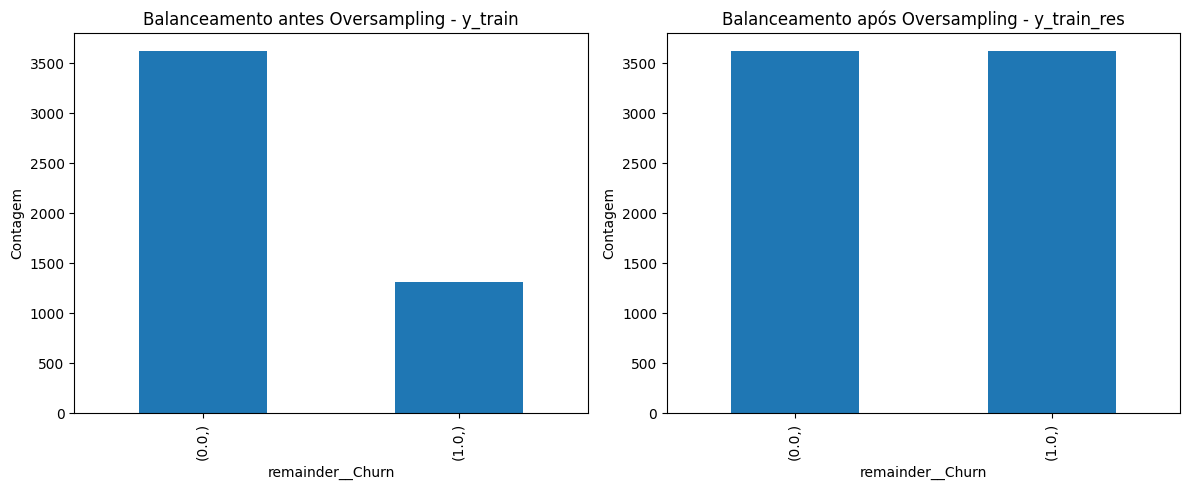

In [8]:
# dentre as opções de undersampling e oversampling, decidi utilizar o oversampling
# minha escolha foi baseada no fato de que o oversampling pode ajudar a identificar melhor a classe minoritária
# nesse caso o 1(sim) da variável alvo, que representa os clientes que optaram por cancelar o serviço
# também considerando que o dataset não é tão grande
# tentarei evitar overfitting com o uso do SMOTE

from imblearn.over_sampling import SMOTE as sm

sm = sm(random_state=42) #random state para reprodutibilidade
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Gráfico para y_train
pd.DataFrame(y_train).value_counts().plot(kind='bar', ax=axs[0], title='Balanceamento antes Oversampling - y_train')
axs[0].set_ylabel('Contagem')
# Gráfico para y_train_res
pd.DataFrame(y_train_res).value_counts().plot(kind='bar', ax=axs[1], title='Balanceamento após Oversampling - y_train_res')
axs[1].set_ylabel('Contagem')
plt.tight_layout()
plt.show()  #



## Análise de correlação

In [9]:
mc = df.corr()
mc = mc['remainder__Churn'].sort_values(ascending=False)
pd.DataFrame(mc)

# Positivo: Quando a variável X aumenta, o Churn tende a ser 1 (mais Churn).
# Negativo: Quando a variável X aumenta, o Churn tende a ser 0 (menos Churn).
# Quanto mais próximo de 1 ou -1: Mais forte a relação.
# Quanto mais próximo de 0: Mais fraca a relação linear.

,remainder__Churn
remainder__Churn,1.000000
onehotencoder__account.Contract_Month-to-month,0.405103
onehotencoder__internet.InternetService_Fiber optic,0.308020
onehotencoder__account.PaymentMethod_Electronic check,0.301919
remainder__account.Charges.Daily,0.193412
remainder__account.Charges.Monthly,0.193356
remainder__customer.SeniorCitizen,0.150889
remainder__phone.PhoneService,0.011942
remainder__customer.gender,-0.008612
onehotencoder__account.PaymentMethod_Mailed check,-0.091683


## Considerações principais da análise de correlação

-- corr Positivos, ou seja, quanto maior a variável maior a taxa de evasão (1) --
- clientes com contrato mensal possuem uma tendência maior de evasão. Contratos mensais não prendem cliente a longo prazo.
- clientes que contratam fibra óptica também estão mais inclinados a evasão. Pode indicar um problema na prestação do serviço.
- clientes que pagam eletronicamente estão mais inclinados a evasão, também pode indicar um roblema na prestação do serviço.

-- corr Negativas, ou seja, quanto maior a variável menor a taxa de evasão (1) --
- clientes com parceiros ou dependentes tem uma tendência um pouco menor a evasão.
- clientes sem serviço de internet tendem a não optar pela evasão, reforçando um problema na prestação desse serviço.
- clientes com contrato de dois anos também tendem a não optar pela evasão, reforçando o tópico anterior.
- clientes com maior tempo na empresa tendem a ficar.


## Análise direcionada aos tópicos principais

In [33]:
def gerar_grafico_countplot(figura_quant, fig_por_fig, col):
    fig, axs = plt.subplots(figura_quant, fig_por_fig, figsize=(30, 10))
    for i in range(len(col)):
        sns.countplot(x=col[i], hue='remainder__Churn', data=df, ax=axs[i])
        axs[i].set_title(f'Churn por {col[i]}')
        axs[i].set_xlabel(f'{col[i]} (0=Não, 1=Sim)')
        axs[i].set_ylabel('Churn (0=Não, 1=Sim)')
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(['Não', 'Sim'])
        axs[i].set_yticks([0, 1])
    plt.tight_layout()
    plt.show()

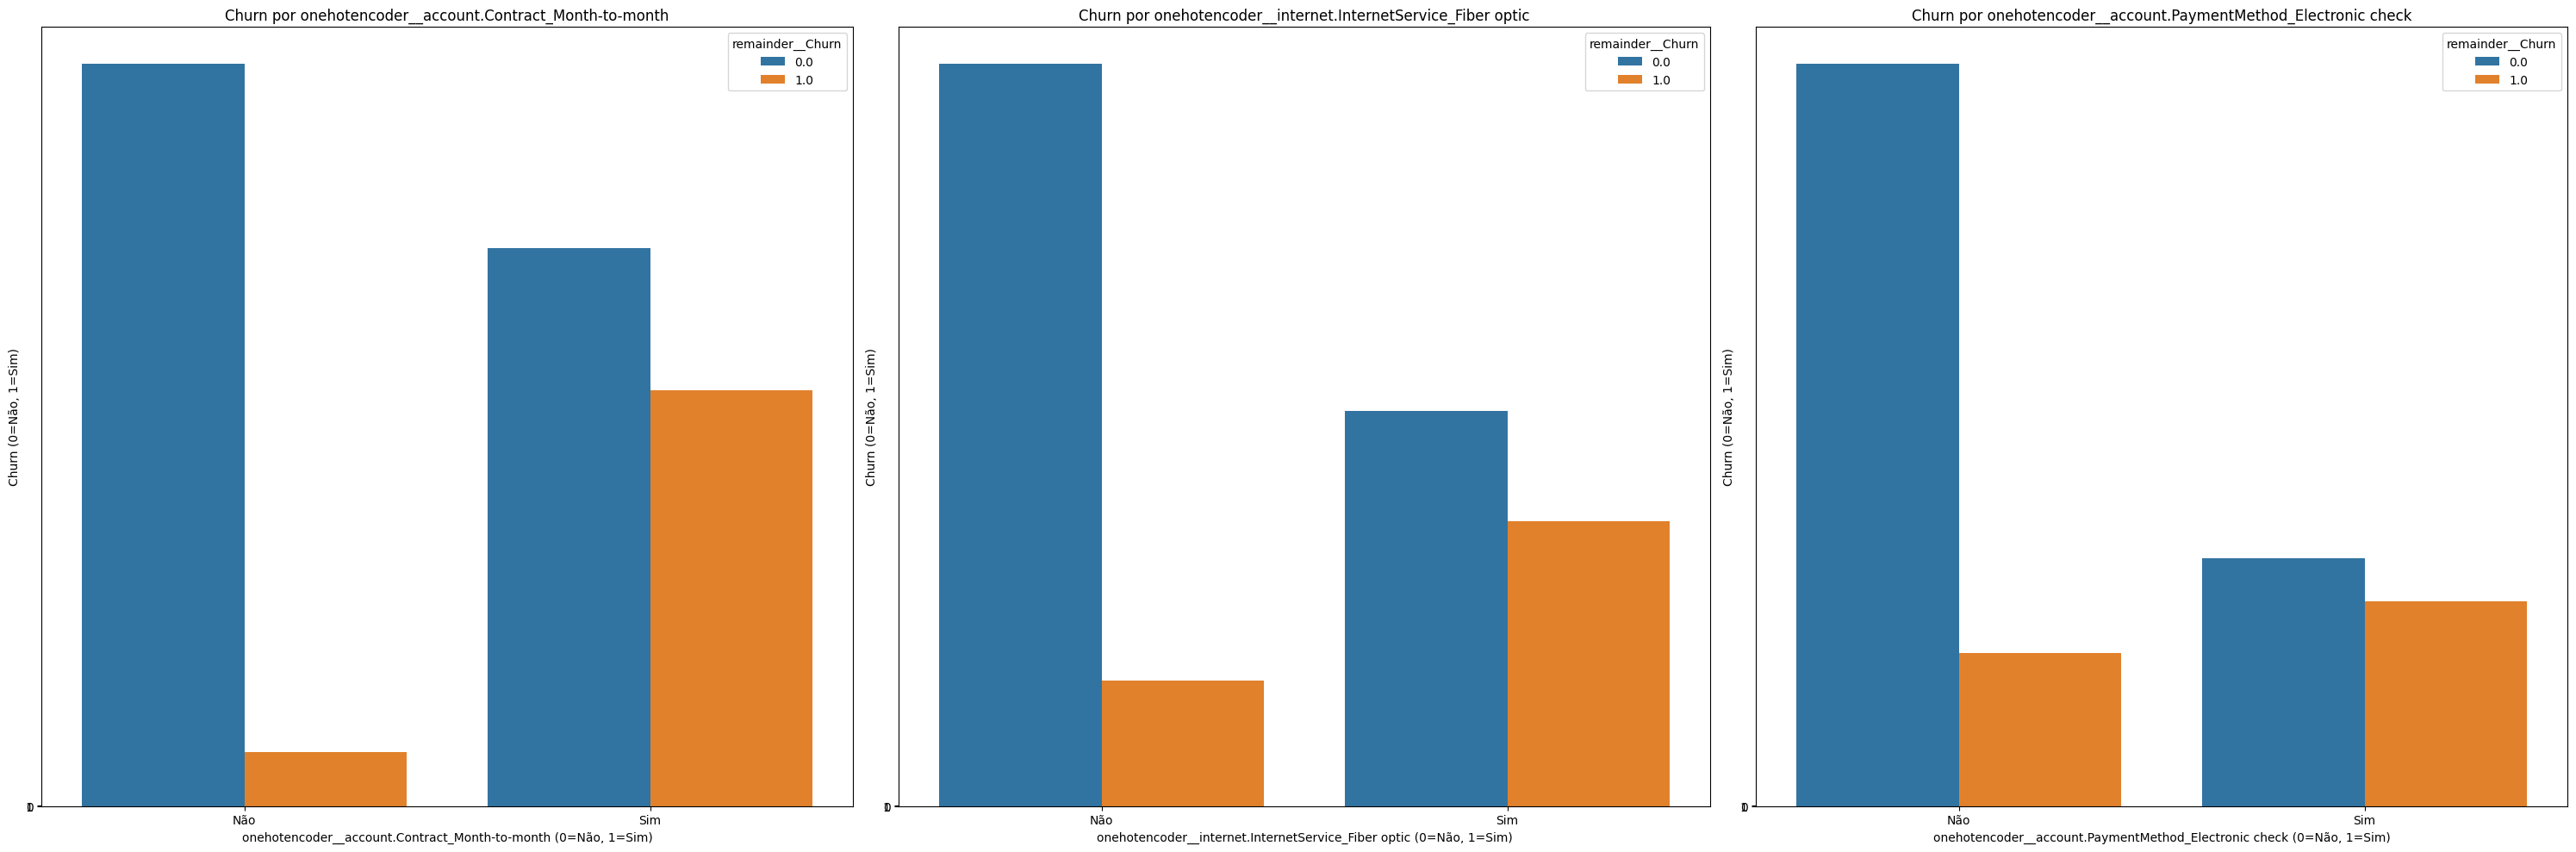

In [34]:
principais_positivos = ['onehotencoder__account.Contract_Month-to-month', 'onehotencoder__internet.InternetService_Fiber optic', 'onehotencoder__account.PaymentMethod_Electronic check']
gerar_grafico_countplot(1,3, principais_positivos)

-- obervações sobre os gráficos --
- no primeiro e segundo gráfico vemos que existe uma relação direta entre clientes que possuem contrato mensal e de fibra ótica indicando que são duas problemáticas reais e significativas
- já no terceiro gráfico vemos que, apesar de a correlação positiva vista anteriorimente, a diferença entre clientes que utilizam ou não o pagamento eletrônico e que optaram pela evasão não é tão descrepante - podendo indicar não ser uma variável TÃO significativa para a análise

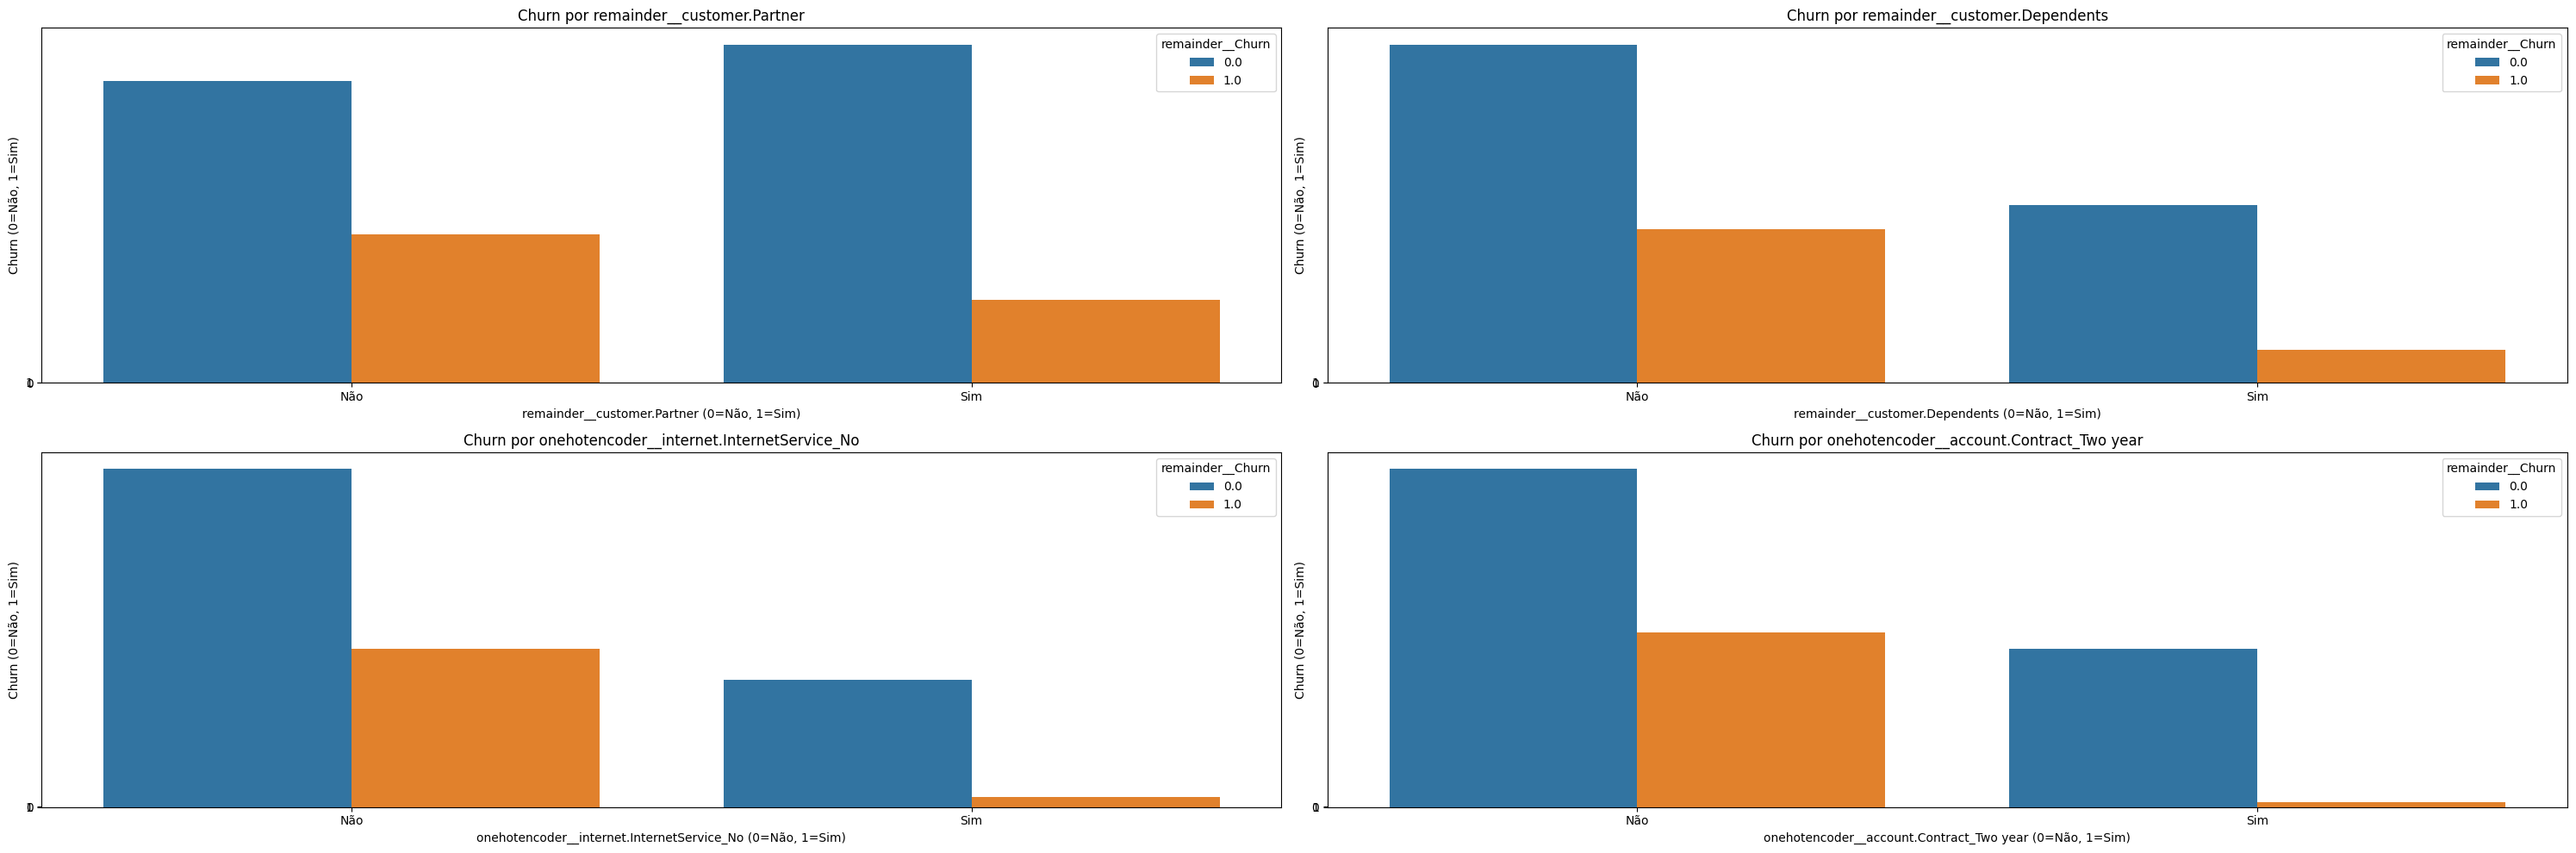

In [37]:
principais_negativos = ['remainder__customer.Partner', 'remainder__customer.Dependents',
						 'onehotencoder__internet.InternetService_No', 
						 'onehotencoder__account.Contract_Two year']
gerar_grafico_countplot(2, 2, principais_negativos)


-- observações sobre os gráficos --
- em todos os gráficos ao analisar que as variáveis possuem de fato uma correlação negativa, ou seja, os clientes que possuem cônjuge, dependentes, que optaram pelo plano anual e não contrataram a internet possuem uma tendência muito menor de adesão a evasão (Churn)

In [38]:
principais_negativos_scatter = ['remainder__account.Charges.Total','remainder__customer.tenure']

In [45]:
def gerar_boxplots(df, colunas_explicativas):
    fig_quant = 1
    fig_por_fig = len(colunas_explicativas)
    fig, axs = plt.subplots(fig_quant, fig_por_fig, figsize=(fig_por_fig * 8, 6))
    if fig_por_fig == 1:
        axs = [axs]
    for i, col in enumerate(colunas_explicativas):
        sns.boxplot(
            x='remainder__Churn',
            y=col,               
            data=df,
            ax=axs[i]
        )
        axs[i].set_title(f'Distribuição de {col} por Churn')
        axs[i].set_xlabel('Churn (0=Não, 1=Sim)')
        axs[i].set_ylabel(col)
        axs[i].set_xticks([0, 1]) 
        axs[i].set_xticklabels(['Não Churn', 'Churn']) 
    plt.tight_layout()
    plt.show()

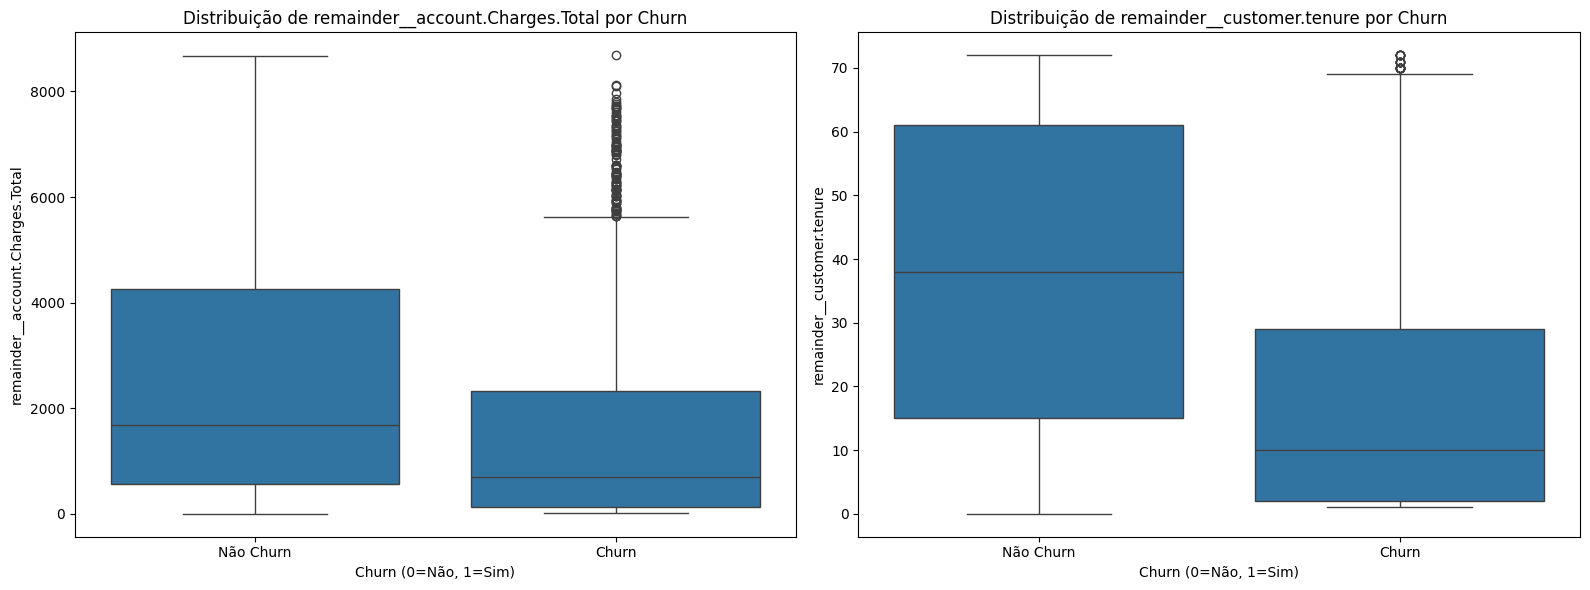

In [46]:
gerar_boxplots(df, principais_negativos_scatter)

-- Considerações sobre o gráfico --

- em charges.Total observamos que clientes que optaram pela evasão, pela mediana, gastaram menos - apesar de observar alguns outliers. Apontando mais uma vez que clientes de longa data costumar continuar com a empresa e/ou que clientes pagando valores maiores estão satisfeitos com o produto oferecido.
- em tenure (tempo que o cliente recebe os serviços) observamos a mesma coisa, porém com uma descrepância muito maior. A mediana de clientes que optaram pela evasão é concentrada em tempos muito mais baixos se comparado a clientes que não optaram pela evasão. Essa distribuição possui uma quantidade insignificante de autliers. Reforçando mais uma vez que a fidelização do cliente.